<a href="https://colab.research.google.com/github/RNavs-44/Neural_Networks/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-03-23 12:40:47--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.08s   

2024-03-23 12:40:48 (2.61 MB/s) - ‘names.txt’ saved [228145/228145]



In [9]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build vocabulary of characters and mapping to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length

def build_dataset(words):
  x, y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      x.append(context)
      y.append(ix)
      context = context[1:] + [ix] # crop and append

  x = torch.tensor(x)
  y = torch.tensor(y)

  return x, y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xts, yts = build_dataset(words[n2:])

In [11]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embd), generator=g)
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5) # x0.3
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [c, w1, b1, w2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12297


In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construction
  ix = torch.randint(0, xtr.shape[0], (batch_size, )) # randint(low, hight, size)
  xb, yb = xtr[ix], ytr[ix]

  # forward pass
  emb = c[xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d} / {max_steps:7d}: {loss.item()}')
  lossi.append(loss.log10().item())

print(loss.item())

      0 /  200000: 3.32480525970459
  10000 /  200000: 2.446129560470581
  20000 /  200000: 2.4671530723571777
  30000 /  200000: 1.9742863178253174
  40000 /  200000: 2.1451587677001953
  50000 /  200000: 2.432570457458496
  60000 /  200000: 1.9758281707763672
  70000 /  200000: 2.1034862995147705
  80000 /  200000: 2.0959479808807373
  90000 /  200000: 1.7195336818695068
 100000 /  200000: 2.09816312789917
 110000 /  200000: 1.9536595344543457
 120000 /  200000: 1.9467417001724243
 130000 /  200000: 2.4135806560516357
 140000 /  200000: 2.1916069984436035
 150000 /  200000: 1.8901985883712769
 160000 /  200000: 2.267315626144409
 170000 /  200000: 2.055544137954712
 180000 /  200000: 2.377354860305786
 190000 /  200000: 2.041982412338257
1.9040037393569946


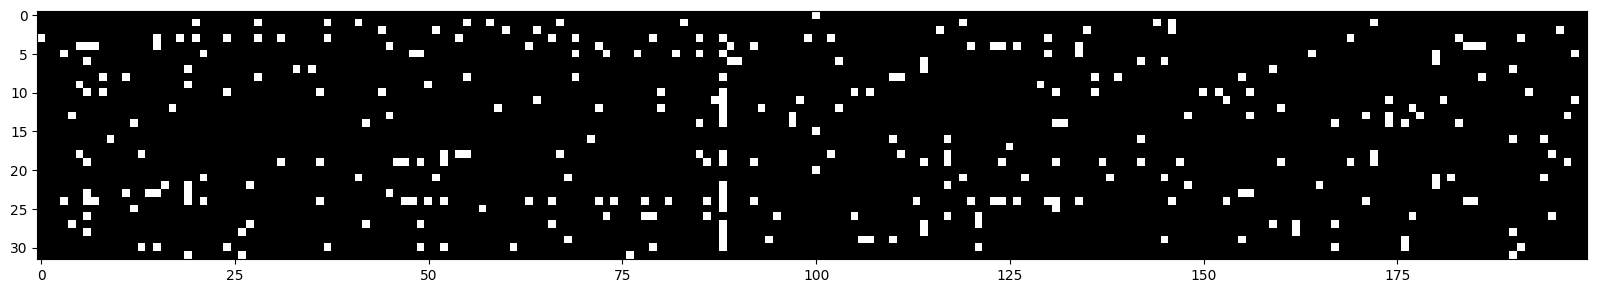

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

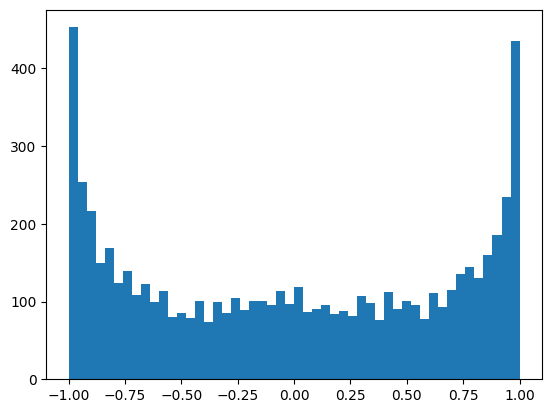

In [14]:
plt.hist(h.view(-1).tolist(), 50);

In [15]:
# expected initial loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

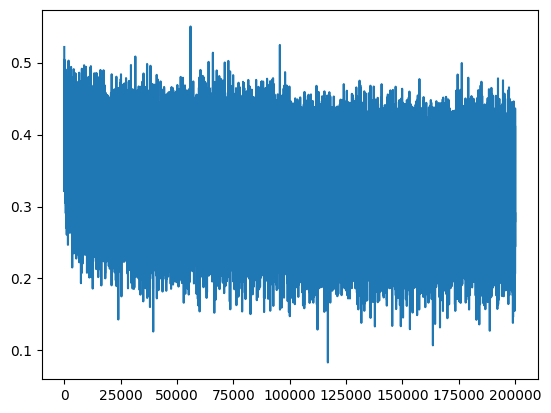

In [16]:
plt.plot(lossi)

In [21]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (xtr, ytr),
      'val': (xdev, ydev),
      'test': (xts, yts),
  }[split]
  emb = c[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0670018196105957
val 2.1055641174316406


In [20]:
# sample from model
for _ in range(50):
  out = []
  context = [0] * block_size
  while True:
    # forward pass neural net
    emb = c[torch.tensor(context)]
    embcat = emb.view(1, -1)
    hpreact = embcat @ w1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim = 1)

    # sample from distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)

    # if we sample special '.' token break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # print generated word

<ipython-input-20-f5cf5e278d7c>:10: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0